In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import pearsonr

# Constants

In [ ]:
CREATE_TAP_MERGED_DATASET = True # Create a merged dataset
DROP_DATE_TIME = ['Date', 'Time'] # Remove redundant date and time feature when required
DROP_TARGET = ['Accident_Severity'] # Convenient drop target feature constant
DROP_FOR_TRAINING = DROP_DATE_TIME + DROP_TARGET # Features only for training

# Initialisation

In [18]:
# Import Accident dataset and modify accordingly
acc = pd.read_csv('acc2005_2016.csv', low_memory=False).drop([
    # Removed because they are duplicate data
    'LSOA_of_Accident_Location', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 
    # Removed because location too specific, favour district level location
    'Longitude', 'Latitude', 
    # Removed because they are unrrelated to this problem
    'Police_Force', 'Number_of_Casualties', 'Number_of_Vehicles', 'Did_Police_Officer_Attend_Scene_of_Accident'
], axis=1).replace(-1, np.nan).rename(columns={
    'Local_Authority_.District.': 'Local_Authority_District',
    'Local_Authority_.Highway.': 'Local_Authority_Highway',
    'Speed_limit': 'Speed_Limit',
    'Pedestrian_Crossing.Human_Control': 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_Crossing.Physical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'
})
acc = acc.dropna()

# Decompose Date and Time to independent features then drop compound feature
acc.loc[:, ('Date')] = pd.to_datetime(acc['Date'])
acc.loc[:, ('Time')] = pd.to_datetime(acc['Time'], format='%H:%M')
acc = acc.assign(Year=acc.Date.dt.year, Month=acc.Date.dt.month, Day=acc.Date.dt.day, Hour=acc.Time.dt.hour, Minute=acc.Time.dt.minute, Is_Weekend=[1 if day == 1 or day == 7 else 0 for day in acc.Day_of_Week])

# Encode string feature to integer
le_jc = LabelEncoder()
le_jc.fit(acc['Local_Authority_Highway'])
acc.loc[:, ('Local_Authority_Highway')] = le_jc.transform(acc['Local_Authority_Highway'])

acc.describe()

,Accident_Severity,Day_of_Week,Local_Authority_District,X1st_Road_Class,X1st_Road_Number,Road_Type,Speed_Limit,Junction_Detail,Junction_Control,X2nd_Road_Class,...,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year,Month,Day,Hour,Minute,Is_Weekend
count,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,...,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06,1.123649e+06
mean,2.862114e+00,4.124149e+00,3.220595e+02,4.140968e+00,1.050610e+03,5.057013e+00,3.532173e+01,3.829983e+00,3.632381e+00,5.226945e+00,...,1.312846e+00,7.592496e-02,3.550753e-02,1.245122e+00,2.010129e+03,6.557808e+00,1.567105e+01,1.368136e+01,2.683563e+01,2.316978e-01
std,3.664848e-01,1.899517e+00,2.561505e+02,1.342703e+00,1.841442e+03,1.814443e+00,1.127924e+01,2.166278e+00,7.736551e-01,1.245487e+00,...,5.511953e-01,5.836576e-01,4.205229e-01,4.302734e-01,3.469045e+00,3.424338e+00,8.654492e+00,4.988425e+00,1.750345e+01,4.219172e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00,9.300000e+01,3.000000e+00,0.000000e+00,6.000000e+00,3.000000e+01,3.000000e+00,4.000000e+00,5.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.007000e+03,4.000000e+00,8.000000e+00,1.000000e+01,1.100000e+01,0.000000e+00
50%,3.000000e+00,4.000000e+00,3.000000e+02,4.000000e+00,1.700000e+02,6.000000e+00,3.000000e+01,3.000000e+00,4.000000e+00,6.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.010000e+03,7.000000e+00,1.600000e+01,1.400000e+01,2.900000e+01,0.000000e+00
75%,3.000000e+00,6.000000e+00,5.000000e+02,6.000000e+00,8.040000e+02,6.000000e+00,3.000000e+01,6.000000e+00,4.000000e+00,6.000000e+00,...,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,1.000000e+01,2.300000e+01,1.700000e+01,4.200000e+01,0.000000e+00
max,3.000000e+00,7.000000e+00,9.410000e+02,6.000000e+00,9.999000e+03,9.000000e+00,7.000000e+01,9.000000e+00,4.000000e+00,6.000000e+00,...,5.000000e+00,7.000000e+00,7.000000e+00,3.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,1.000000e+00


In [28]:
acc.columns

Index(['Accident_Index', 'Accident_Severity', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_District', 'Local_Authority_Highway',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_Limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_Crossing_Human_Control',
       'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Is_Weekend'],
      dtype='object')

In [19]:
# Import Vehicle dataset and modify accodingly
veh = pd.read_csv('veh2005_2016.csv').drop([
    # Removed because they are duplicate data
     'Age_of_Driver', 
    # Removed because they are unrrelated to this problem
    'Towing_and_Articulation', 'Skidding_and_Overturning', 'Vehicle_Reference', 
    # Removed because they have > 50% missing value
    'Driver_IMD_Decile', 'Vehicle_IMD_Decile'
], axis=1).replace(-1, np.nan).rename(columns={
    'Was_Vehicle_Left_Hand_Drive.': 'Was_Vehicle_Left_Hand_Drive',
    'Vehicle_Location.Restricted_Lane': 'Vehicle_Location_Restricted_Lane',
    'Engine_Capacity_.CC.': 'Engine_Capacity_CC'
})
veh[['Propulsion_Code']] = veh[['Propulsion_Code']].replace('M', np.nan)
veh = veh.dropna()

veh.describe()

,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location_Restricted_Lane,Junction_Location,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,X1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_CC,Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type
count,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06,2.053116e+06
mean,9.494104e+00,1.255914e+01,8.552025e-02,2.544846e+00,3.302298e-01,4.381555e-01,6.660101e-01,1.805842e+00,1.000923e+00,8.069814e+00,1.341831e+00,6.797342e+00,1.895011e+03,1.362221e+00,7.337716e+00,1.342554e+00
std,5.012872e+00,6.142658e+00,7.893215e-01,3.156504e+00,1.675729e+00,1.500053e+00,2.258582e+00,1.131639e+00,3.036669e-02,5.670860e+00,4.773818e-01,1.751335e+00,1.683150e+03,6.472717e-01,4.588340e+00,6.872542e-01
min,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,9.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,1.294000e+03,1.000000e+00,4.000000e+00,1.000000e+00
50%,9.000000e+00,1.700000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,7.000000e+00,1.598000e+03,1.000000e+00,7.000000e+00,1.000000e+00
75%,9.000000e+00,1.800000e+01,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.500000e+01,2.000000e+00,8.000000e+00,1.994000e+03,2.000000e+00,1.000000e+01,1.000000e+00
max,9.800000e+01,1.800000e+01,9.000000e+00,8.000000e+00,1.200000e+01,8.000000e+00,1.100000e+01,4.000000e+00,2.000000e+00,1.500000e+01,3.000000e+00,1.100000e+01,9.999900e+04,1.200000e+01,1.080000e+02,3.000000e+00


In [29]:
veh.columns

Index(['Accident_Index', 'Vehicle_Type', 'Vehicle_Manoeuvre',
       'Vehicle_Location_Restricted_Lane', 'Junction_Location',
       'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway',
       'Hit_Object_off_Carriageway', 'X1st_Point_of_Impact',
       'Was_Vehicle_Left_Hand_Drive', 'Journey_Purpose_of_Driver',
       'Sex_of_Driver', 'Age_Band_of_Driver', 'Engine_Capacity_CC',
       'Propulsion_Code', 'Age_of_Vehicle', 'Driver_Home_Area_Type'],
      dtype='object')

In [20]:
# Create a merged dataset
if CREATE_TAP_MERGED_DATASET:
    tap = acc.merge(veh, on='Accident_Index').drop(['Accident_Index'], axis=1)
    tap.describe()

# Functions 

In [21]:
# Count number of missing values and display
def count_missing_values(data):
    len_total = len(data)
    for col in data.columns:
        sum_na = sum(data[col].isnull())
        if sum_na > 0:
            print('Column: {};\t\t\t Missing data amount (%): {} ({})'.format(col, round(sum_na/len_total * 100, 4), sum_na))
            for yr in range(min(tap['Year']), max(tap['Year']) + 1):
                print('\tYear: {}\t(%) Missing: {}'.format(yr, len(list(filter(lambda x: x == True, tap.loc[tap['Year'] == yr][col].isnull()))) / len(tap.loc[tap['Year'] == yr]) * 100))
                
                
# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=nearest_workday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=nearest_workday),
        Holiday('Boxing Day', month=12, day=26, observance=after_nearest_workday)
    ]
    
# Used for any bank holidays that happen 2 days in a row
def after_nearest_workday(dt):
    """
    returns next workday after nearest workday
    needed for Boxing day or multiple holidays in a series
    """
    return next_workday(nearest_workday(dt))

# General utility function to generate a graph with acc, cas and veh lines in same plot
def gen_util_plotter(subplot, **kwargs):
    subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['y'].reshape(-1, 1)), marker='o', label='Accidents')
    if 'cv' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['c'].reshape(-1, 1)), marker='1', label='Casualties')
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['v'].reshape(-1, 1)), marker='8', label='Vehicles')
    elif 'c' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['c']['c'].reshape(-1, 1)), marker='1', label='Casualties')
    elif 'v' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['v']['v'].reshape(-1, 1)), marker='8', label='Vehicles')
    if 'title' in kwargs:
        subplot.set_title(kwargs['title'])
    if 'set_xticks' in kwargs:
        if kwargs['set_xticks']:
            subplot.set_xticks(x)
    subplot.legend()

# General utility function to slice data series into feature specified
def gen_xyunzip_list(data, feature):
    return map(np.array, 
                   zip(*[(i, len(data.loc[data[feature] == i])) 
                         for i in range(min(data[feature]), max(data[feature]) + 1)]))

# General utility function to generate a dictionary with merging specialisation
# WARNING: TIGHTLY COUPLED WITH CODEBASE
def gen_cv_list(feature, **kwargs):
    if kwargs is None:
        return -1
    ret = dict()
    acc_idx = [acc.loc[acc[feature] == i].set_index('Accident_Index').index 
               for i in range(min(acc[feature]), max(acc[feature]) + 1)]
    if 'c' in kwargs:
        ret['c'] = np.array([len(cas[cas.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    if 'v' in kwargs:
        ret['v'] = np.array([len(veh[veh.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    
    return ret

# Pearson correlation coefficient
def pearsonr_correlation_list(data, target):
    return pd.DataFrame.from_records(sorted([pc for pc in zip([pearsonr(target, data[feature])[0] for feature in data.columns], data.columns)], reverse=True), columns=['Correlation_Value', 'Feature'])

# Get list of Pearson correlation coefficient that is within specified range
# If pos_corr or neg_corr is set to None, set positive and negative correlation to third and first quartile
# FIXME
def get_pearsonr_high(pearsonr_list, pos_corr=None, neg_corr=None):
    if type(pearsonr_list) is not pd.DataFrame:
        pearsonr_list = pd.DataFrame.from_records(pearsonr_list)
        corr_val_colname = pearsonr_list.columns[0]
        feature_colname = pearsonr_list.columns[1]
    else:
        corr_val_colname = pearsonr_list.columns[0]
        feature_colname = pearsonr_list.columns[1]
    if pos_corr is None:
        pos_ls = pd.DataFrame([pos for pos in pearsonr_list[corr_val_colname] if pos >= 0], columns=['pos'])
        pos_corr = pos_ls['pos'].quantile(.25)
    if neg_corr is None:
        neg_ls = pd.DataFrame([neg for neg in pearsonr_list[corr_val_colname] if neg < 0], columns=['neg'])
        neg_corr = neg_ls['neg'].quantile(.25)
    return pd.DataFrame.from_records(zip(sorted(list(filter(lambda y: y >= pos_corr or y <= neg_corr, pearsonr_list[corr_val_colname])), reverse=True), pearsonr_list[feature_colname]), columns=['Correlation_Value', 'Feature'])
    
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


# General analysis

C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


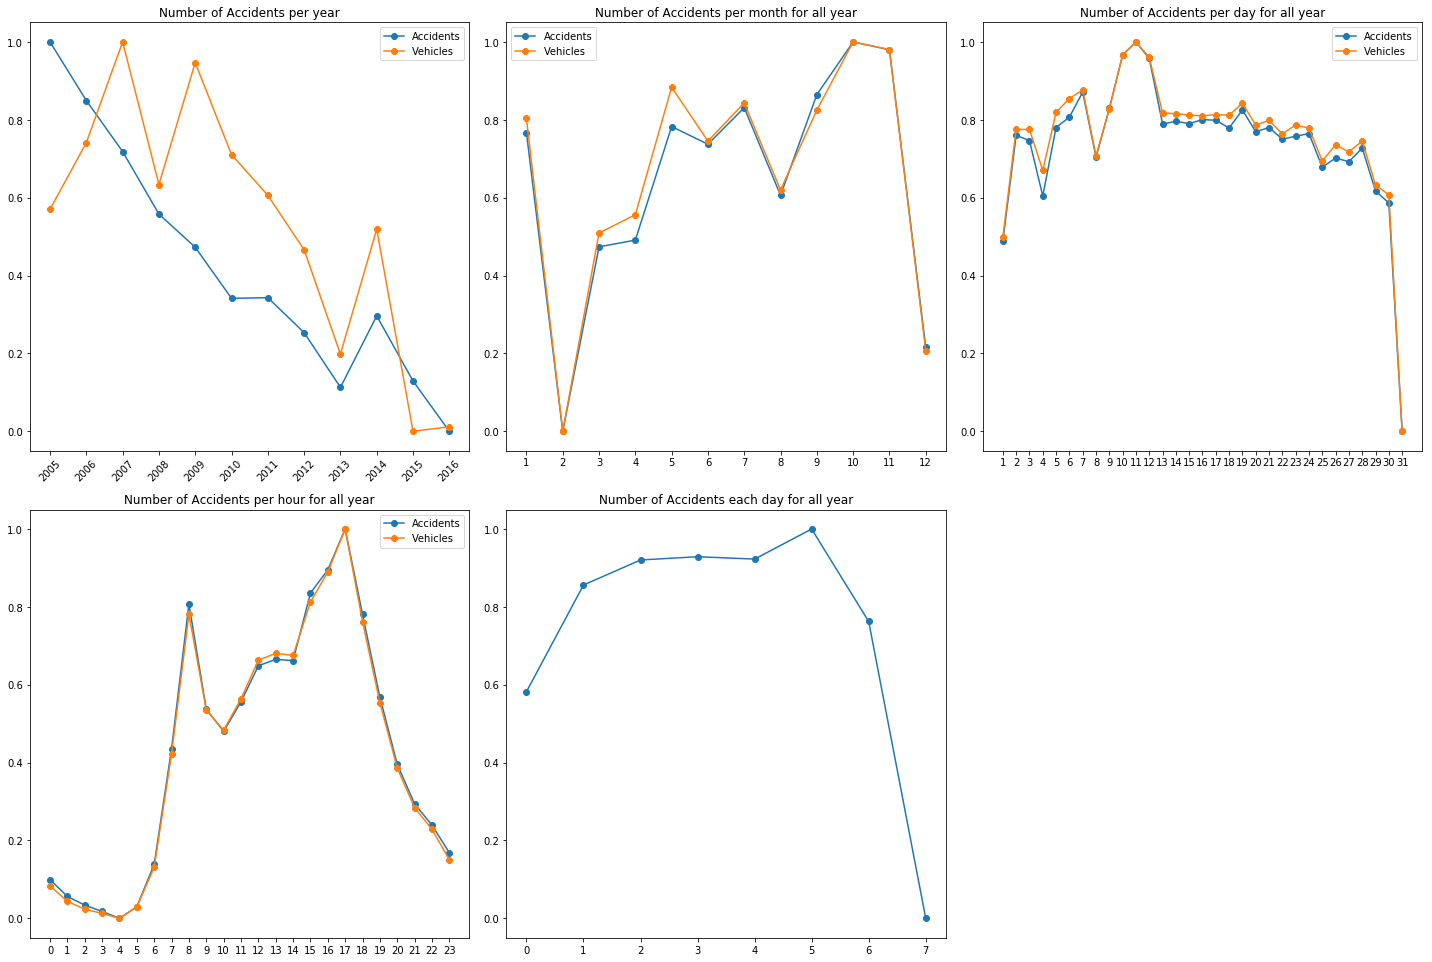

In [22]:
min_max_scaler = MinMaxScaler()
fig_general = plt.figure(figsize=[20,20])
nrow, ncol, splt_ind = 3, 3, 1

# Display plot for accidents per year
x, y = gen_xyunzip_list(acc, 'Year')
v = gen_cv_list('Year', v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, v=v, title='Number of Accidents per year', set_xticks=True)
ax.set_xticklabels(x, rotation=45)
splt_ind += 1

# Display plot for accident per month for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Month')
v = gen_cv_list('Month', v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, v=v, title='Number of Accidents per month for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per day for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Day')
v = gen_cv_list('Day', v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, v=v, title='Number of Accidents per day for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per hour for all years
x, y = gen_xyunzip_list(acc, 'Hour')
v = gen_cv_list('Hour', v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, v=v, title='Number of Accidents per hour for all year', set_xticks=True)
splt_ind += 1

ukhol = UKBankHolidays()
# Display plot for accident for each day for all years
# TODO: Holidays + Weekend as 7
# Legend:
#    0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday
ukbh = UKBankHolidays()
hols = ukbh.holidays(min(acc.Date), max(acc.Date))

acc_date_ind = acc.set_index('Date').index
acc_hols = acc_date_ind.isin(hols)

x = np.array([i for i in range(0, 8)])
y = np.array([len(acc.loc[acc['Day_of_Week'] == i]) for i in range(1, 8)])
y = np.append(y, [len(list(filter(lambda x: x == True, acc_hols)))])

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
ax.plot(x, min_max_scaler.fit_transform(y.reshape(-1, 1)), marker='o')
ax.set_title('Number of Accidents each day for all year')
ax.set_xticks(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
splt_ind += 1

plt.tight_layout()
plt.show()

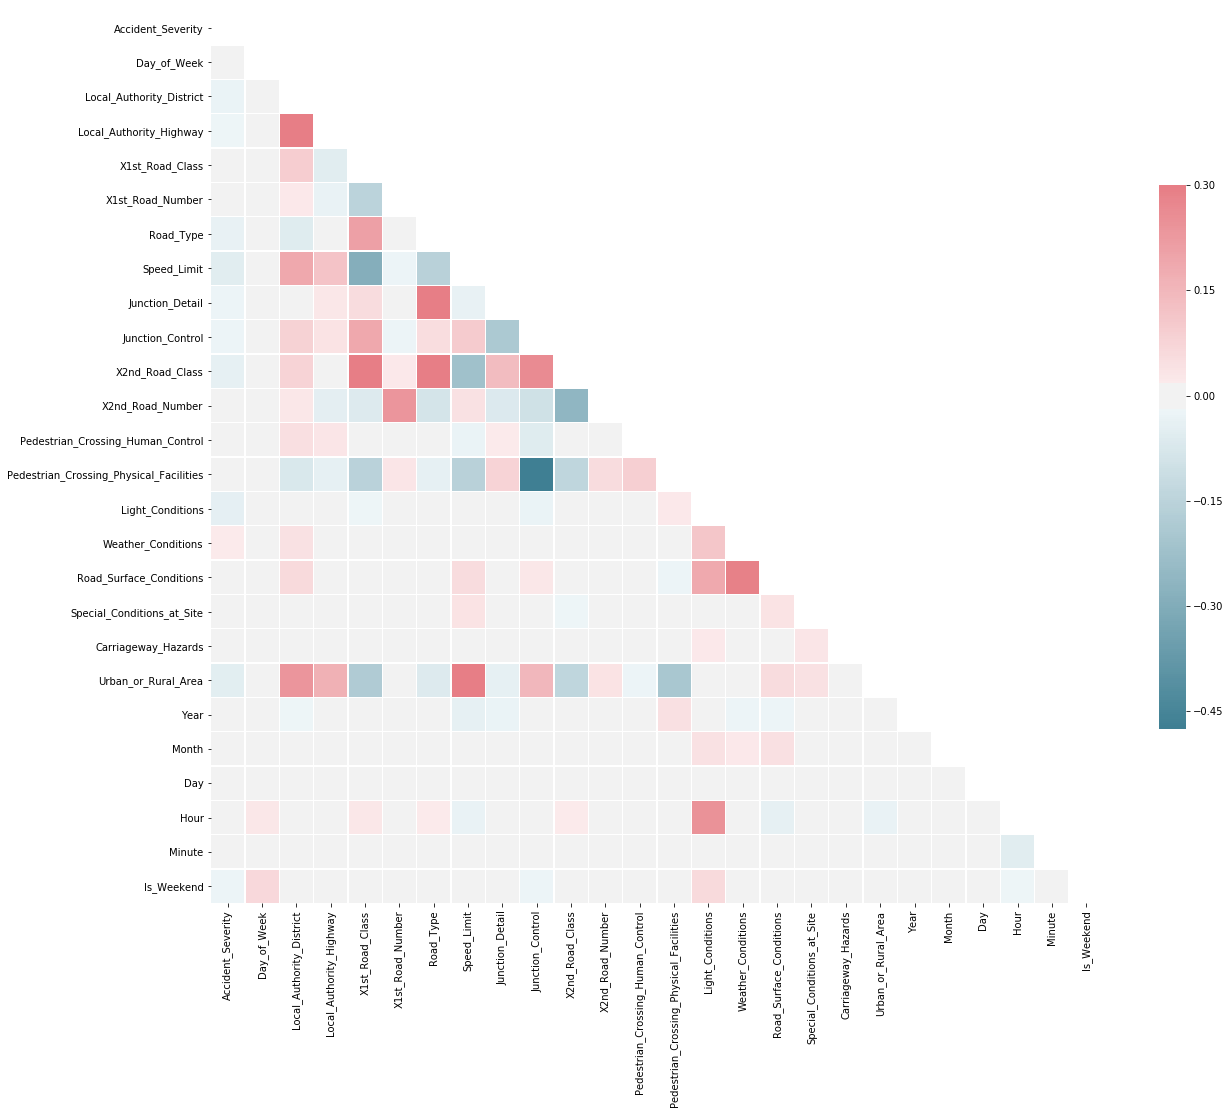

In [23]:
plot_pearsonr(acc)

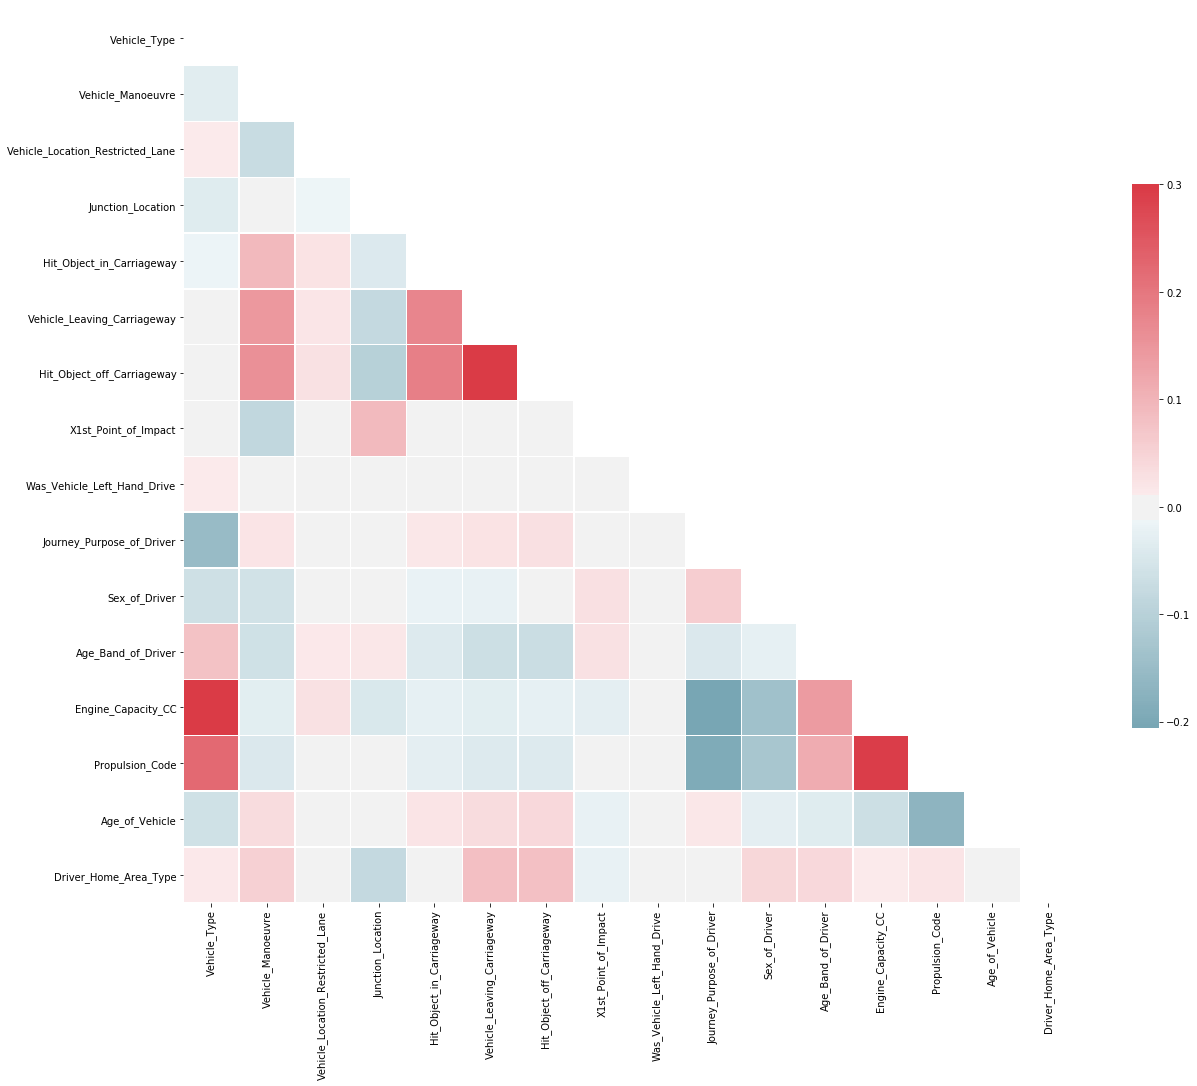

In [24]:
plot_pearsonr(veh)

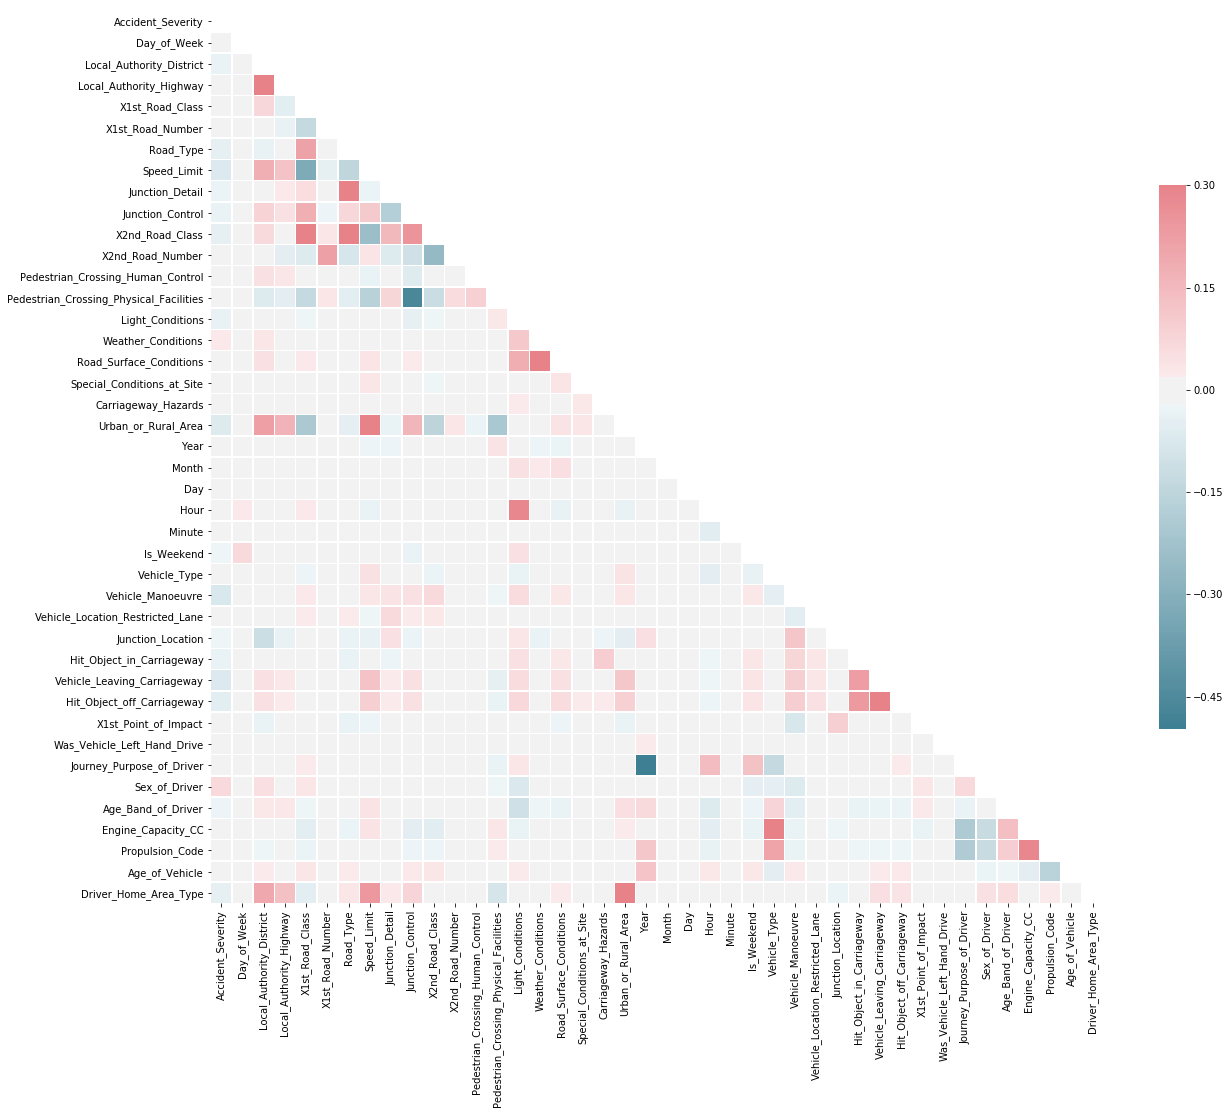

In [25]:
plot_pearsonr(tap)

In [26]:
tap_high_corr = get_pearsonr_high(pearsonr_correlation_list(tap.drop(DROP_DATE_TIME + ['Accident_Severity'], axis=1), tap['Accident_Severity']))

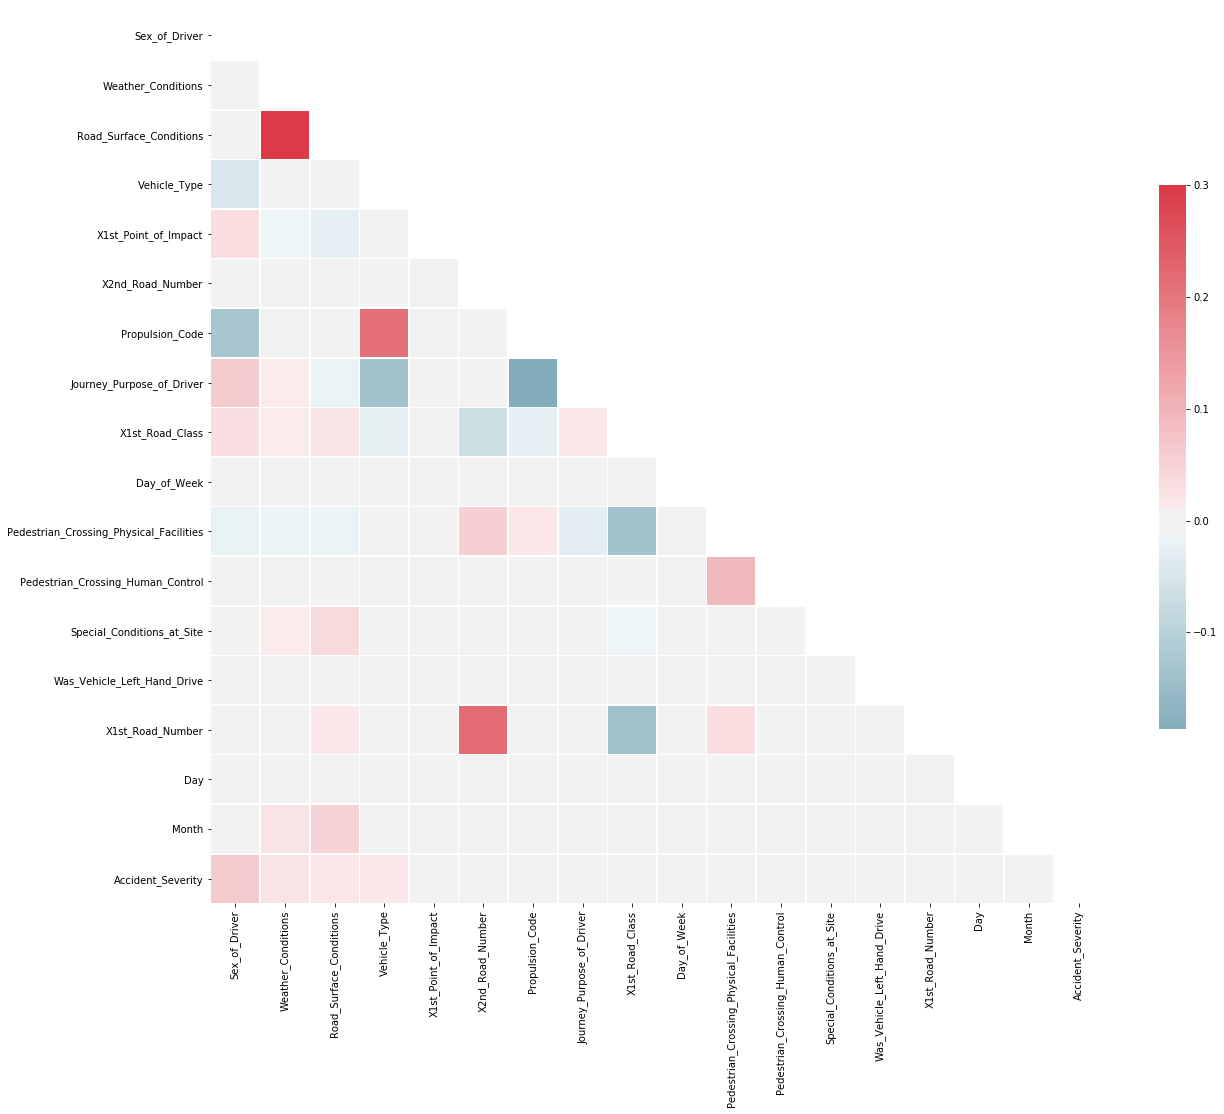

In [27]:
plot_pearsonr(tap[list(tap_high_corr['Feature']) + DROP_TARGET])

In [31]:
tap_high_corr

,Correlation_Value,Feature
0,0.064215,Sex_of_Driver
1,0.023571,Weather_Conditions
2,0.019027,Road_Surface_Conditions
3,0.016235,Vehicle_Type
4,0.011051,X1st_Point_of_Impact
5,0.009988,X2nd_Road_Number
6,0.008216,Propulsion_Code
7,0.007664,Journey_Purpose_of_Driver
8,0.007393,X1st_Road_Class
9,0.003561,Day_of_Week
